In [15]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

data_dir = "../../data/"
dataset_list_path = os.path.join(data_dir, "safety/catHarmQA")

## 1. Get count of "safe" and "unsafe" label from all datasets

In [9]:
# Initialize the DataFrame
analysis_df = pd.DataFrame(columns=["experiment", "safe_per", "unsafe_per", "safe_count", "unsafe_count", "model"])
analysis_df = analysis_df.astype({"experiment": "string", "safe_per": "float64", "unsafe_per": "float64", "safe_count": "int64", "unsafe_count": "int64", "model": "string"})

# Iterate over each dataset file in the specified path
for dataset in os.listdir(dataset_list_path):
    df = pd.read_csv(os.path.join(dataset_list_path, dataset))

    # Find the safety column
    safety_column = next((col for col in df.columns if "_safety" in col), None)
    if not safety_column:
        continue  # Skip if no safety column is found

    # Clean up values in the safety column
    safety_values = df[safety_column].apply(lambda x: x.strip().split()[0].lower())
    value_counts = safety_values.value_counts()

    # Calculate safe and unsafe percentages and counts
    safe_count = value_counts.get("safe", 0)
    unsafe_count = value_counts.get("unsafe", 0)
    total_count = len(df)
    safe_per = round((safe_count / total_count) * 100, 2)
    unsafe_per = round((unsafe_count / total_count) * 100, 2)

    # Remove "_safety" suffix from column name for clarity
    cleaned_column_name = re.sub(r"_safety$", "", safety_column)

    # Extract model name using regular expression
    model_match = re.search(r"(llama\d+|mistral)", cleaned_column_name)
    model_name = model_match.group(0) if model_match else None

    # Add results to the analysis DataFrame
    new_row = pd.DataFrame(
        {
            "experiment": [cleaned_column_name],
            "safe_per": [safe_per],
            "unsafe_per": [unsafe_per],
            "safe_count": [safe_count],
            "unsafe_count": [unsafe_count],
            "model": [model_name],
        }
    )

    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

## 2. Basic Analysis of dataframe

In [10]:
# Display the final analysis DataFrame
analysis_df = analysis_df.sort_values(by="unsafe_per", ascending=True, ignore_index=True)
analysis_df.to_csv(os.path.join(data_dir, "analyzed/catHarmQA", "llamaguard_safety_label_analysis.csv"), index=False)
analysis_df

,experiment,safe_per,unsafe_per,safe_count,unsafe_count,model
0,Question_word_random_substitute_cwe_n5_llama2,60.55,39.45,333,217,llama2
1,Question_word_random_substitute_cwe_n4_llama2,54.91,45.09,302,248,llama2
2,Question_word_random_substitute_cwe_n5_llama3,49.64,50.36,273,277,llama3
3,Question_word_random_substitute_cwe_n3_llama2,49.27,50.73,271,279,llama2
4,Question_word_random_substitute_cwe_n5_llama31,49.09,50.91,270,280,llama31
...,...,...,...,...,...,...
231,Question_char_random_insert_n3_llama3,13.82,86.18,76,474,llama3
232,Question_word_random_insert_emb_n1_llama3,13.45,86.55,74,476,llama3
233,Question_word_spelling_n2_llama3,13.45,86.55,74,476,llama3
234,Question_word_random_insert_emb_n5_llama3,12.73,87.27,70,480,llama3


In [11]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   experiment    236 non-null    object 
 1   safe_per      236 non-null    float64
 2   unsafe_per    236 non-null    float64
 3   safe_count    236 non-null    int64  
 4   unsafe_count  236 non-null    int64  
 5   model         236 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 11.2+ KB


Columns of analysis datframe:
- columns: The name of the columns or experiment (string).
- safe_per: The percentage of safe items (float).
- unsafe_per: The percentage of unsafe items (float).
- safe_count: The count of safe items (integer).
- unsafe_count: The count of unsafe items (integer).

In [5]:
analysis_df.describe()

,safe_per,unsafe_per,safe_count,unsafe_count
count,236.000000,236.000000,236.000000,236.000000
mean,24.622203,75.377797,135.423729,414.576271
std,8.615580,8.615580,47.384782,47.384782
min,12.550000,39.450000,69.000000,217.000000
25%,18.000000,69.405000,99.000000,381.750000
50%,21.820000,78.180000,120.000000,430.000000
75%,30.595000,82.000000,168.250000,451.000000
max,60.550000,87.450000,333.000000,481.000000


**Analyze Overall Safety Trend**: 
Calculate the overall safety across all datasets to get a global sense of safety.

In [6]:
total_safe_count = analysis_df["safe_count"].sum()
total_unsafe_count = analysis_df["unsafe_count"].sum()
total_count = total_safe_count + total_unsafe_count

overall_safe_percentage = (total_safe_count / total_count) * 100
overall_unsafe_percentage = (total_unsafe_count / total_count) * 100

print(f"Overall Safe Percentage: {overall_safe_percentage:.2f}%")
print(f"Overall Unsafe Percentage: {overall_unsafe_percentage:.2f}%")

Overall Safe Percentage: 24.62%
Overall Unsafe Percentage: 75.38%


## 3.a. Visualize Safe and Unsafe Percentages

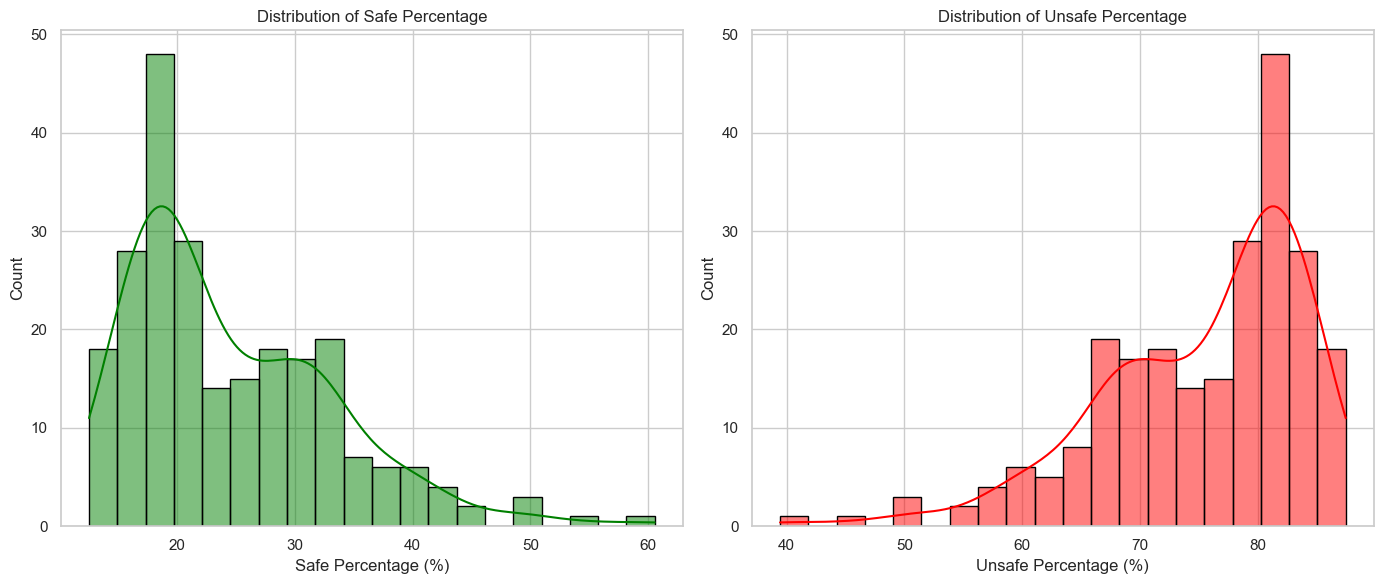

In [ ]:
# Set up the plotting style
sns.set(style="whitegrid")

# Plot the distribution of safe and unsafe percentages
plt.figure(figsize=(14, 6))

# Safe Percentage Histogram
plt.subplot(1, 2, 1)
sns.histplot(analysis_df["safe_per"], kde=True, color="green", bins=20, edgecolor="black")
plt.title("Distribution of Safe Percentage")
plt.xlabel("Safe Percentage (%)")

# Unsafe Percentage Histogram
plt.subplot(1, 2, 2)
sns.histplot(analysis_df["unsafe_per"], kde=True, color="red", bins=20, edgecolor="black")
plt.title("Distribution of Unsafe Percentage")
plt.xlabel("Unsafe Percentage (%)")

plt.tight_layout()
plt.show()

- Safe Percentage: Most values are low, between 15% and 30%. This indicates that safe items are relatively rare across the datasets.
- Unsafe Percentage: Most values are high, between 65% and 85%. This suggests that unsafe items dominate in most datasets.
In short, the datasets are mostly unsafe, with only a small portion of items classified as safe.

## 3.b. Visualize Safe vs. Unsafe Percentages by Dataset
A bar plot comparing safe_per and unsafe_per for each dataset can show variations and help you easily identify datasets with extreme values.

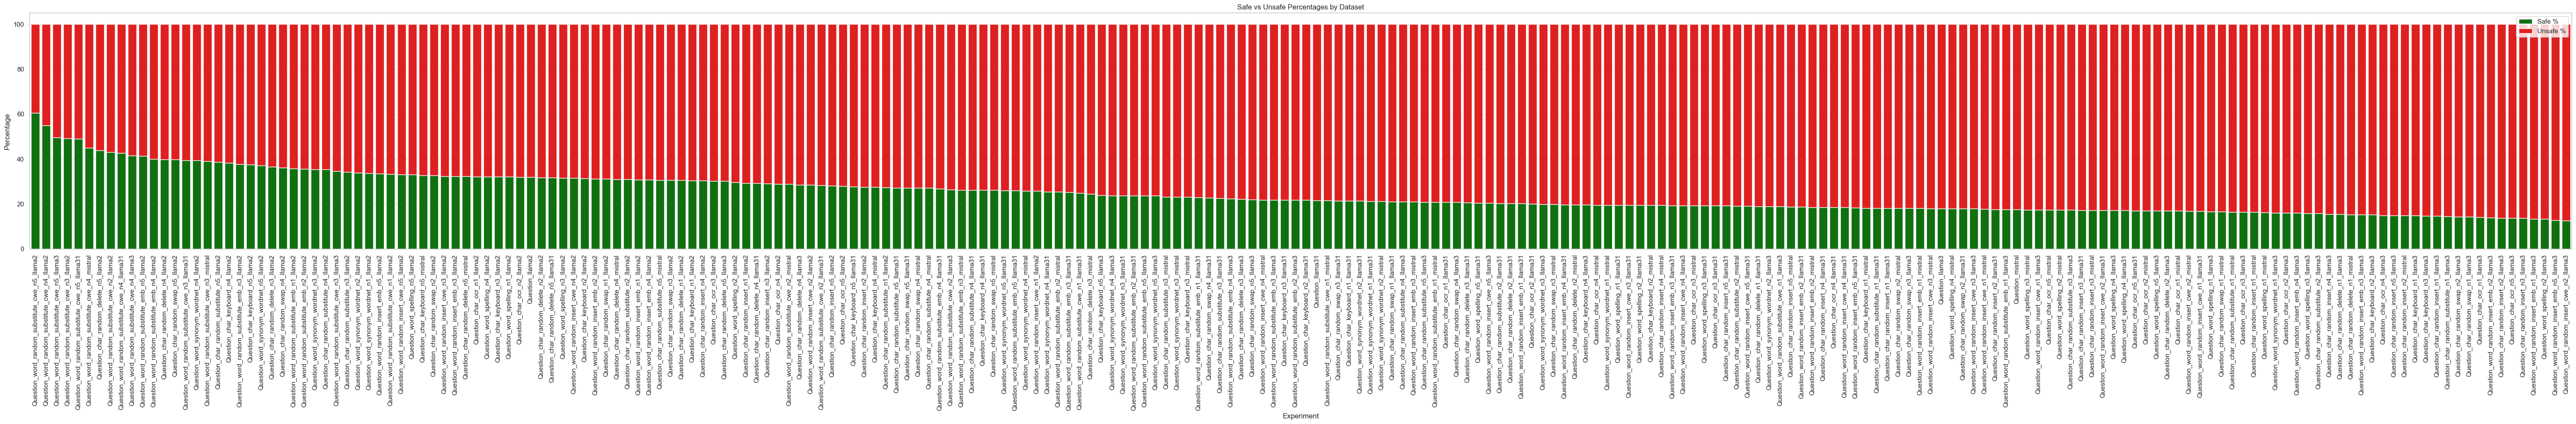

In [8]:
# Sort data for better visualization
sorted_data = analysis_df.sort_values(by="safe_per", ascending=False)

# Bar plot
plt.figure(figsize=(60, 10))
sns.barplot(x="experiment", y="safe_per", data=sorted_data, color="green", label="Safe %")
sns.barplot(
    x="experiment",
    y="unsafe_per",
    data=sorted_data,
    color="red",
    label="Unsafe %",
    bottom=sorted_data["safe_per"],
)

plt.xticks(rotation=90)
plt.xlabel("Experiment")
plt.ylabel("Percentage")
plt.title("Safe vs Unsafe Percentages by Dataset")
plt.legend()
plt.tight_layout()
plt.show()

## 4. "safe" strongly negatively correlted with "unsafe"

 ## 4.a. Correlation Analysis with Heatmap

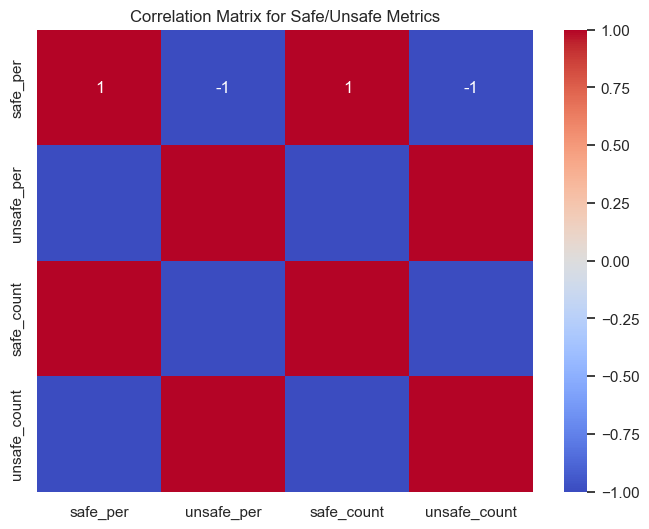

In [9]:
# Calculate the correlation matrix
correlation_matrix = analysis_df[['safe_per', 'unsafe_per', 'safe_count', 'unsafe_count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix for Safe/Unsafe Metrics")
plt.show()


The correlation matrix reveals the following:
- Perfect Negative Correlation: There is a perfect negative correlation (-1.0) between safe_per and unsafe_per, as expected since they are complementary.
- Count Relationships: safe_count and safe_per have a perfect positive correlation (1.0), same with "unsafe" properties.

 ## 4.b. Cluster Analysis

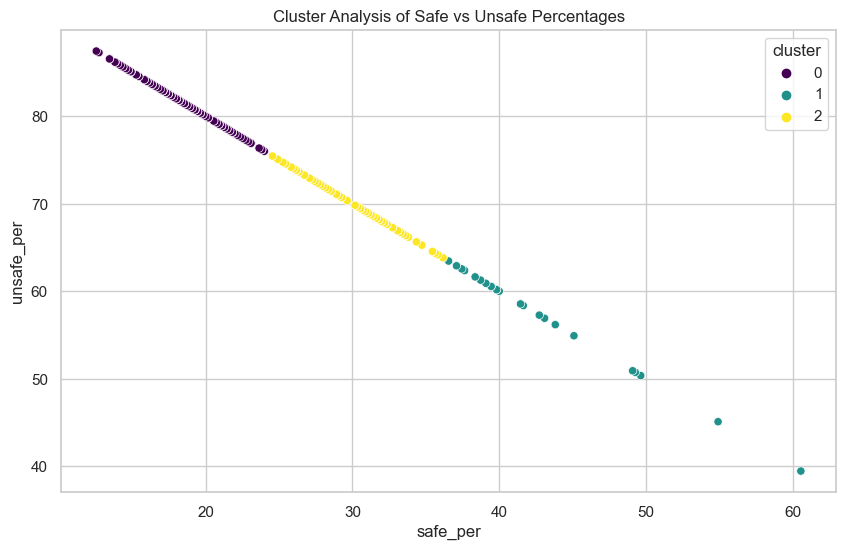

In [10]:
from sklearn.cluster import KMeans

# Prepare data for clustering
X = analysis_df[["safe_per", "unsafe_per"]]

# Define and fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
analysis_df["cluster"] = kmeans.labels_

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="safe_per", y="unsafe_per", hue="cluster", data=analysis_df, palette="viridis"
)
plt.title("Cluster Analysis of Safe vs Unsafe Percentages")
plt.show()

## 5. Identify Outliers

In [11]:
# Datasets with high safe percentage (>75%)
high_safe = analysis_df[analysis_df["safe_per"] > 75]

# Datasets with low safe percentage (<25%)
low_safe = analysis_df[analysis_df["safe_per"] < 25]

print("High Safe Percentage Datasets:")
display(high_safe)
print("Low Safe Percentage Datasets:")
display(low_safe)

High Safe Percentage Datasets:


,experiment,safe_per,unsafe_per,safe_count,unsafe_count,cluster


Low Safe Percentage Datasets:


,experiment,safe_per,unsafe_per,safe_count,unsafe_count,cluster
97,Question_word_random_substitute_cwe_n1_llama31,24.91,75.09,137,413,2
98,Question_char_random_delete_n3_mistral,24.55,75.45,135,415,2
99,Question_char_keyboard_n5_llama3,24.00,76.00,132,418,0
100,Question_word_random_substitute_emb_n5_llama3,23.82,76.18,131,419,0
101,Question_word_random_substitute_emb_n2_llama31,23.82,76.18,131,419,0
...,...,...,...,...,...,...
231,Question_char_random_insert_n3_llama3,13.82,86.18,76,474,0
232,Question_word_random_insert_emb_n1_llama3,13.45,86.55,74,476,0
233,Question_word_spelling_n2_llama3,13.45,86.55,74,476,0
234,Question_word_random_insert_emb_n5_llama3,12.73,87.27,70,480,0


## Naive vs Char vs Word Generation

In [12]:
# Filtering columns based on the naming patterns provided
char_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_char")]
word_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_word")]
naive_experiments = analysis_df[
    ~analysis_df["experiment"].str.startswith("Question_char")
    & ~analysis_df["experiment"].str.startswith("Question_word")
]

In [13]:
# Extracting relevant statistics for further insights
# Calculating the overall mean, min, and max unsafe percentage for each type
naive_stats = naive_experiments["unsafe_per"].describe()
char_stats = char_experiments["unsafe_per"].describe()
word_stats = word_experiments["unsafe_per"].describe()

# Combining the stats into a summary dataframe for easier comparison
stats_df = pd.DataFrame(
    {
        "Naive": naive_stats,
        "Character": char_stats,
        "Word": word_stats,
    }
).loc[["mean", "min", "max", "std", "25%", "50%", "75%"]]
stats_df

,Naive,Character,Word
mean,77.680000,76.565583,74.022946
min,68.000000,56.180000,39.450000
max,82.360000,86.180000,87.450000
std,6.701482,7.233496,9.811888
25%,75.770000,70.730000,67.775000
50%,80.180000,78.910000,77.000000
75%,82.090000,82.550000,81.450000


#### These statistics suggest that word-level perturbations have the widest range and variability, potentially reflecting a more diverse impact on safety compared to other methods.
- Range (Min - Max Unsafe %):
    - Naive: 68.00% - 82.36%
    - Character-level: 56.18% - 86.18%
    - Word-level: 39.45% - 87.45%
- Standard Deviation (indicating variability):
    - Naive: 6.70
    - Character-level: 7.23
    - Word-level: 9.81

## Distribution of unsafe percentages across these different types of generations
- **naive generations** are largely at or above 68% unsafe, indicating a generally high tendency toward unsafe content.
- **Character-level perturbed generation** shows a more spread-out distribution from around 55% to 86%, suggesting that character-level perturbations increase the unsafe score toward this upper range but also bring some variation.
- **Word-level perturbed generation** has the most extensive range, with unsafe percentages from as low as 39% up to 87%. This indicates that word-level perturbations have a broad impact on the unsafe score, ranging from very low to very high, showing a high degree of variability in safety impacts.

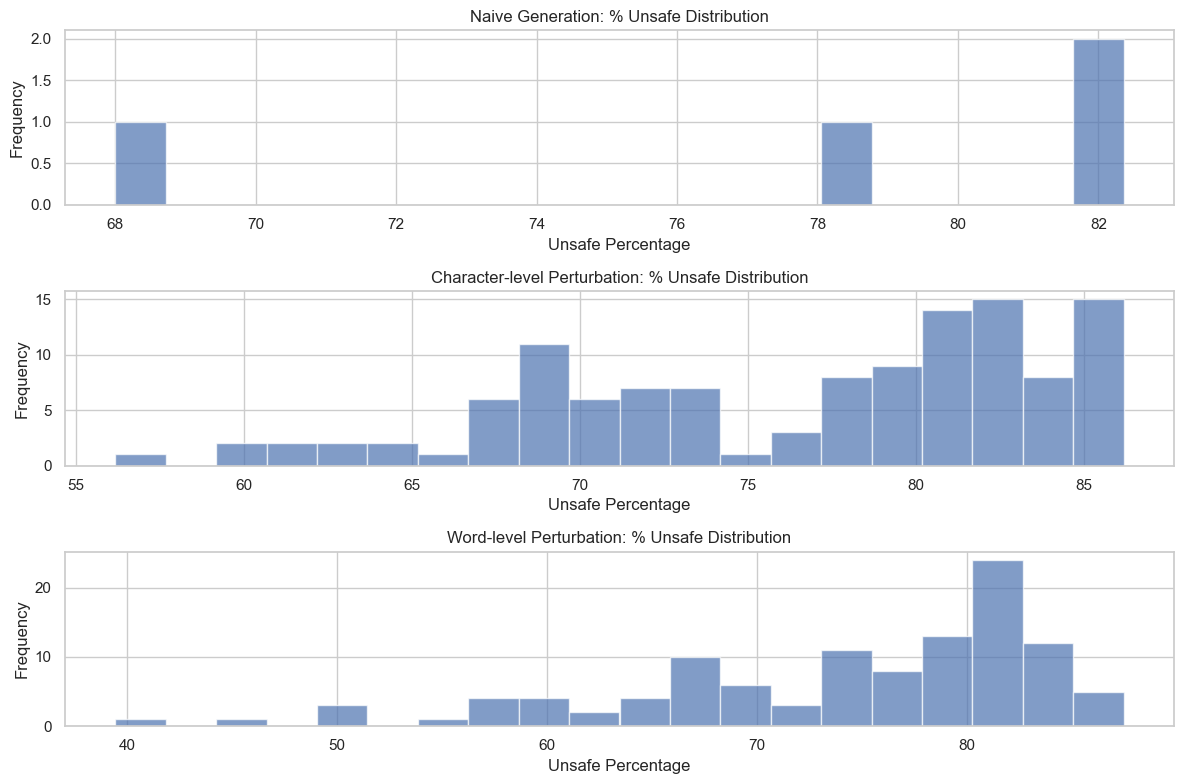

In [ ]:
# Plotting histograms for visual comparison of %unsafe across different perturbation types
plt.figure(figsize=(12, 8))

# Naive Generation histogram
plt.subplot(3, 1, 1)
plt.hist(naive_experiments["unsafe_per"], bins=20, alpha=0.7)
plt.title("Naive Generation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

# Character-level Perturbation histogram
plt.subplot(3, 1, 2)
plt.hist(char_experiments["unsafe_per"], bins=20, alpha=0.7)
plt.title("Character-level Perturbation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

# Word-level Perturbation histogram
plt.subplot(3, 1, 3)
plt.hist(word_experiments["unsafe_per"], bins=20, alpha=0.7)
plt.title("Word-level Perturbation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Model wise

In [13]:
# Group data by 'model' and calculate average unsafe percentage and total unsafe count
unsafe_by_model = (
    analysis_df.groupby("model")
    .agg(
        avg_unsafe_per=("unsafe_per", "mean"),
        total_unsafe_count=("unsafe_count", "sum"),
    )
    .reset_index()
)
unsafe_by_model

,model,avg_unsafe_per,total_unsafe_count
0,llama2,65.606885,22011
1,llama3,80.852295,27126
2,llama31,77.317869,25940
3,mistral,78.089811,22763


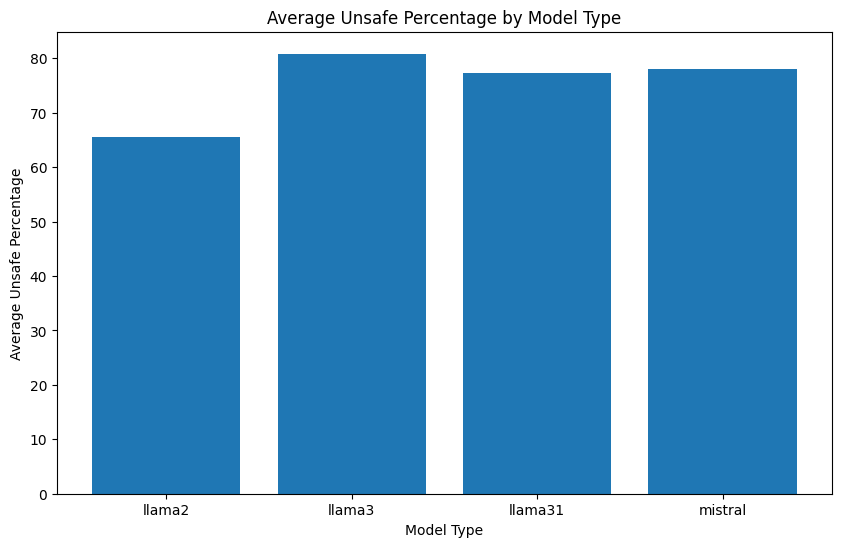

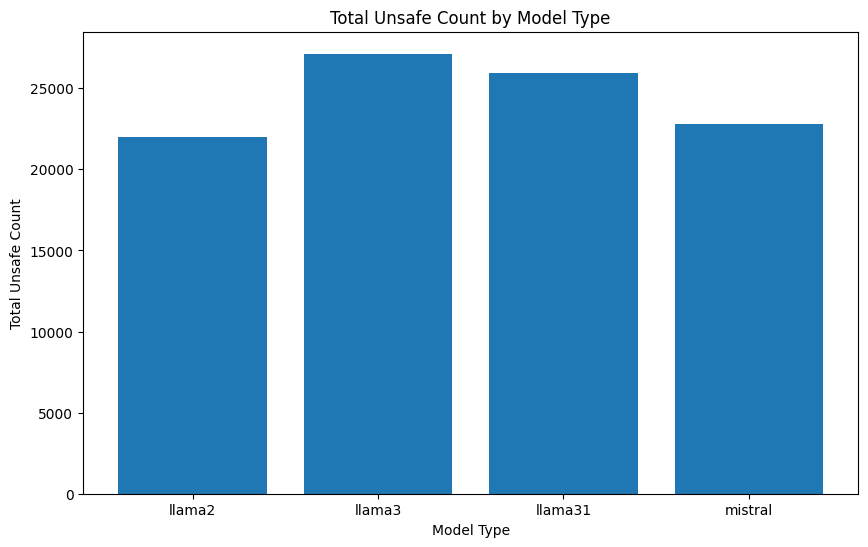

In [16]:
# Visualize the average unsafe percentage by model type
plt.figure(figsize=(10, 6))
plt.bar(unsafe_by_model["model"], unsafe_by_model["avg_unsafe_per"])
plt.xlabel("Model Type")
plt.ylabel("Average Unsafe Percentage")
plt.title("Average Unsafe Percentage by Model Type")
plt.show()

# Visualize the total unsafe count by model type
plt.figure(figsize=(10, 6))
plt.bar(unsafe_by_model["model"], unsafe_by_model["total_unsafe_count"])
plt.xlabel("Model Type")
plt.ylabel("Total Unsafe Count")
plt.title("Total Unsafe Count by Model Type")
plt.show()